In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

In [2]:
big_files_path = 'output/big_files/'
parsed_files_list =[ 'data29_01_2017__21_29_12ADD.csv',
                   'data30_01_2017__00_04_43ADD.csv',
                         'FINAL_data30_01_2017__06_33_11ADD.csv',
                          'data30_01_2017__14_35_18ADD.csv',
                         'data30_01_2017__21_36_42ADD.csv',
                         'data31_01_2017__19_17_49ADD.csv',
                   'FINAL_data01_02_2017__07_45_01ADD.csv']
parsed_df = []
for parsed_file in tqdm(parsed_files_list):
    #print(parsed_file)
    df1 = pd.read_csv(big_files_path + parsed_file,sep=';',encoding='cp1251')
    
    if len(parsed_df)!=0:
        parsed_df = pd.concat([parsed_df,df1])
    else:
        parsed_df = df1.copy()
df = parsed_df.iloc[np.random.permutation(len(parsed_df))]
df = df.reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.74it/s]


In [3]:
df.columns

Index(['Unnamed: 0', 'Address', 'Balcony', 'Built_year', 'Description',
       'Floor', 'Home_type', 'ID', 'Kitsp', 'Lift', 'Link', 'Livesp',
       'Metro_station', 'Metro_time', 'Nfloor', 'Parking', 'Price', 'Remont',
       'Roof_hight', 'Sales_type', 'Sdacha_GK', 'Search_group', 'Tel', 'Totsp',
       'View', 'WC', 'Walk_metro', 'dist', 'is_premium', 'lat', 'lon',
       'parsing_date', 'publication_date', 'rooms', 'sale'],
      dtype='object')

In [9]:
for publication_date list(df['publication_date'].unique()):
    if 'span' in publication_date:
        

False

In [122]:
from datetime import datetime
def to_time(a):
    if ('span' in a)|(a=='0'):
        b = None
    else:
        #print(a)
        b =  datetime.fromtimestamp( float(a)).hour #+datetime.fromtimestamp( float(a)).minute/60
    return b

In [124]:
df['publication_date_time'] = list(map(to_time,list(df['publication_date']) ))

In [120]:
filt = (df['Price'].notnull())  & (df['publication_date_time'].notnull())& (df['Price']<100e6)

In [95]:
df['publication_date_time'].iloc[0]

0.0

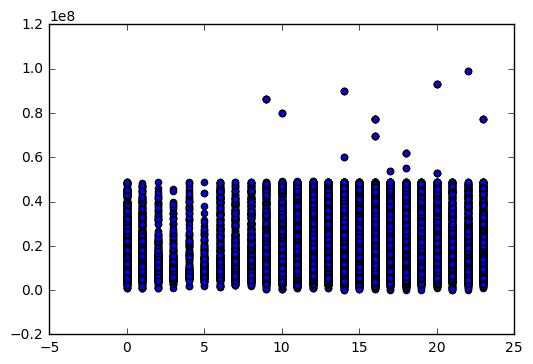

In [96]:
plt.scatter(df[filt]['publication_date_time'],df[filt]['Price'])
plt.show()

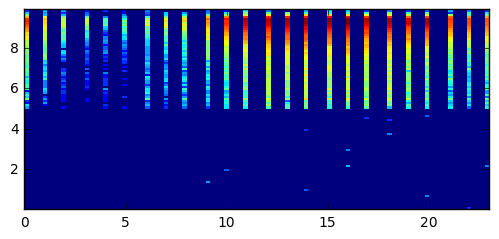

In [125]:
heat_map(list(df[filt]['publication_date_time']),np.array(df[filt]['Price'])/1e7)

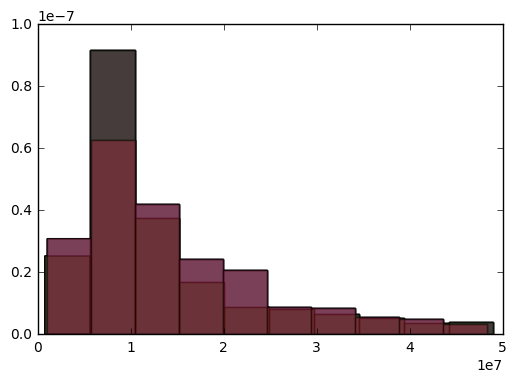

In [145]:
out_filt = df['Price']<50e6
for hour in range(24):
    plt.hist(df[df['publication_date_time']==hour&out_filt]['Price'],alpha=0.3,normed=True)
plt.show()

In [150]:
df[['publication_date_time','publication_date','Link','Price','Address']].tail()

,publication_date_time,publication_date,Link,Price,Address
84408,20.0,1471454488,http://www.cian.ru/sale/flat/148983379/,6800000,"Москва, район Царицыно, Ереванская ул., 31"
84409,11.0,1477297269,http://www.cian.ru/sale/flat/150640171/,24244706,"Москва, район Бабушкинский, ул. Искры, 3"
84410,23.0,1480709239,http://www.cian.ru/sale/flat/151848778/,14000000,"Москва, район Строгино, ул. Исаковского, 4К2"
84411,17.0,1484058271,http://www.cian.ru/sale/flat/152684221/,12600000,"Москва, район Басманный, Нижняя Красносельска..."
84412,20.0,1484759006,http://www.cian.ru/sale/flat/152967585/,5300000,"Москва, Внуковское поселение, район Внуковско..."


In [103]:
list(df[filt]['publication_date_time'])

[0.0,
 22.0,
 22.0,
 14.0,
 19.0,
 0.0,
 21.0,
 9.0,
 11.0,
 12.0,
 21.0,
 10.0,
 20.0,
 1.0,
 20.0,
 13.0,
 16.0,
 14.0,
 16.0,
 10.0,
 14.0,
 11.0,
 20.0,
 9.0,
 21.0,
 20.0,
 18.0,
 17.0,
 15.0,
 18.0,
 15.0,
 14.0,
 16.0,
 12.0,
 8.0,
 15.0,
 23.0,
 2.0,
 20.0,
 16.0,
 15.0,
 12.0,
 11.0,
 21.0,
 20.0,
 12.0,
 18.0,
 13.0,
 14.0,
 20.0,
 17.0,
 14.0,
 11.0,
 11.0,
 15.0,
 19.0,
 11.0,
 18.0,
 14.0,
 13.0,
 10.0,
 16.0,
 0.0,
 16.0,
 19.0,
 20.0,
 22.0,
 16.0,
 12.0,
 22.0,
 17.0,
 17.0,
 16.0,
 7.0,
 15.0,
 12.0,
 17.0,
 22.0,
 15.0,
 11.0,
 12.0,
 20.0,
 17.0,
 20.0,
 15.0,
 11.0,
 10.0,
 12.0,
 16.0,
 14.0,
 11.0,
 15.0,
 11.0,
 13.0,
 12.0,
 14.0,
 10.0,
 13.0,
 17.0,
 17.0,
 16.0,
 11.0,
 23.0,
 21.0,
 0.0,
 22.0,
 7.0,
 17.0,
 18.0,
 13.0,
 12.0,
 13.0,
 13.0,
 17.0,
 12.0,
 14.0,
 16.0,
 12.0,
 19.0,
 16.0,
 12.0,
 2.0,
 23.0,
 23.0,
 8.0,
 19.0,
 16.0,
 12.0,
 14.0,
 0.0,
 18.0,
 21.0,
 17.0,
 16.0,
 14.0,
 15.0,
 14.0,
 15.0,
 18.0,
 14.0,
 15.0,
 12.0,
 10.0,
 17.0,
 0.0,


In [100]:
df[filt]['Price'].isnull()

0        False
1        False
2        False
3        False
4        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
18       False
19       False
22       False
23       False
24       False
26       False
27       False
28       False
29       False
30       False
31       False
32       False
35       False
36       False
         ...  
84377    False
84378    False
84379    False
84380    False
84381    False
84382    False
84383    False
84384    False
84385    False
84387    False
84389    False
84390    False
84391    False
84392    False
84393    False
84394    False
84395    False
84396    False
84398    False
84399    False
84400    False
84402    False
84403    False
84404    False
84407    False
84408    False
84409    False
84410    False
84411    False
84412    False
Name: Price, dtype: bool

In [25]:
d1[3]

'2017-01-19 00:58:39'

In [54]:
df['publication_date_time'].isnull()

0        False
1        False
2        False
3        False
4        False
5         True
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17        True
18       False
19       False
20        True
21        True
22       False
23       False
24       False
25        True
26       False
27       False
28       False
29       False
         ...  
84383    False
84384    False
84385    False
84386     True
84387    False
84388     True
84389    False
84390    False
84391    False
84392    False
84393    False
84394    False
84395    False
84396    False
84397     True
84398    False
84399    False
84400    False
84401     True
84402    False
84403    False
84404    False
84405     True
84406     True
84407    False
84408    False
84409    False
84410    False
84411    False
84412    False
Name: publication_date_time, dtype: bool

### Convert data

In [5]:
df['Balcony']

0                      нет
1                  1 лодж.
2                  1 лодж.
3                        –
4                  1 лодж.
5        1 балк. + 1 лодж.
6                        –
7                  1 балк.
8                  1 балк.
9                  1 лодж.
10                 2 балк.
11                 1 лодж.
12       1 балк. + 1 лодж.
13       1 балк. + 1 лодж.
14                 1 лодж.
15       1 балк. + 1 лодж.
16       1 балк. + 1 лодж.
17                 1 балк.
18                 2 балк.
19                       –
20                 1 лодж.
21                 1 лодж.
22                 1 лодж.
23                 1 балк.
24                 1 лодж.
25                 1 балк.
26                 1 лодж.
27                     нет
28                 1 балк.
29                       –
               ...        
84383              1 балк.
84384              2 балк.
84385              1 лодж.
84386              1 лодж.
84387                  нет
84388    1 балк. + 1 лодж.
8

In [10]:
import re
#Rooms
df['rooms'].value_counts()
df['rooms'] = df['rooms'].fillna(0)
rooms_int = []
for i in tqdm(range(len(df['rooms']))):
    if 'с' in str(df['rooms'].iloc[i]):
        rooms_int.append(0)
    else:
        rooms_int.append(  int(df['rooms'].iloc[i]) )
df['rooms_int'] = rooms_int

# Balcony
df['Balcony'].fillna('-')
Balcony_int =[]
for i in range(len(df['Balcony'])):
    #print(df['Balcony'].iloc[i])
    list_n = re.findall(r'\b\d+\b',str(df['Balcony'].iloc[i]) )
    #print(list_n)
    if len(list_n)!=0:
        Balcony_int.append(sum(list(map(int, list_n))))
    else:
        Balcony_int.append(0)
df['Balcony_int']=Balcony_int

df['Lift'].fillna('-')
Lift_int = []
# Lift
for i in range(len(df['Lift'])):
    list_n = re.findall(r'\b\d+\b',str(df['Lift'].iloc[i]) )
    if len(list_n)!=0:
        Lift_int.append(sum(list(map(int, list_n))))
    else:
        Lift_int.append(0)
df['Lift_int']=Lift_int

100%|█████████████████████████████████████████████████████████████████████████| 84413/84413 [00:04<00:00, 19596.99it/s]


In [7]:
Balcony_int

NameError: name 'Balcony_int' is not defined

In [11]:
import re
import time
import math
df['Roof_hight'].fillna(0)
Roof_hight_fl = []
for i in tqdm(range(len(df['Lift']))):
    str1 = re.sub('м', '', str(df['Roof_hight'].iloc[i]))
    str1 = re.sub(' ', '', str1)
    str1 = re.sub(',', '', str1)
    a = float(str1)
    if a==a:
        a = a/10**math.trunc(math.log10(a))
    else:
        a=0
    Roof_hight_fl.append(a)
df['Roof_hight_fl'] = Roof_hight_fl

 11%|████████▏                                                                 | 9319/84413 [00:00<00:03, 21761.80it/s]


ValueError: could not convert string to float: '2\xa0700\xa0'

#### Clean data

In [12]:
import time 
New_int=[]
for i in range(len(df)):
    a = df['Home_type'].iloc[i]
    if 'новостро' in a:
        New_int.append(1)
    elif 'вторич' in a:
        New_int.append(0)
    else:
        New_int.append(-1)
        print(a)
        print('Неопозннаый тип',end =' ')
        time.sleep(1)
df['New_int'] = New_int
df['Built_year'] = df['Built_year'].fillna(0)
df['Nfloor'] = df['Nfloor'].fillna(np.mean(df['Nfloor']))


In [8]:
sum(df['Kitsp'].isnull())

12047

In [10]:
features

['Balcony_int',
 'Built_year',
 'Floor',
 'New_int',
 'Lift_int',
 'Nfloor',
 'Totsp',
 'dist',
 'lat',
 'lon',
 'Kitsp']

In [14]:
df.columns

Index(['Unnamed: 0', 'Address', 'Balcony', 'Built_year', 'Description',
       'Floor', 'Home_type', 'ID', 'Kitsp', 'Lift', 'Link', 'Livesp',
       'Metro_station', 'Metro_time', 'Nfloor', 'Parking', 'Price', 'Remont',
       'Roof_hight', 'Sales_type', 'Sdacha_GK', 'Search_group', 'Tel', 'Totsp',
       'View', 'WC', 'Walk_metro', 'dist', 'is_premium', 'lat', 'lon',
       'parsing_date', 'publication_date', 'rooms', 'sale', 'New_int'],
      dtype='object')

In [18]:
from sklearn.model_selection import KFold
import time
features = ['Balcony_int','Built_year','Floor','New_int','Lift_int','Nfloor','Totsp','dist',
          'lat', 'lon','Kitsp']
#features = ['Totsp','lat', 'lon']

# 'Kitsp', 'Livesp','Metro_station', 'Metro_time', 'Parking' ,'Remont' ,'Sales_type', 'Tel','View', 'WC',
#       'Walk_metro', 'publication_date'
Y_test_pred_ALL = []
target_feature = 'Price'
out_filter = (df[target_feature]>1e6)& (df['Built_year']>1000) & (df[target_feature]<50e6)
df_clean = df[out_filter][features + [target_feature]].dropna()

kf = KFold(n_splits = 3,shuffle= False)
kf.get_n_splits(df_clean)
print('Start time:', time.strftime("%H:%M:%S"))
for train_index, test_index in kf.split(df_clean):
    #print("TRAIN:", train_index, "TEST:", test_index)

    #Y = np.array(df_clean[target_feature])
    #X = df_clean[features].as_matrix()

    #X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.33, random_state=42)
    X_train = df_clean[features].iloc[train_index].as_matrix()
    Y_train = df_clean[target_feature].iloc[train_index].as_matrix()
    X_test = df_clean[features].iloc[test_index].as_matrix()
    Y_test = df_clean[target_feature].iloc[test_index].as_matrix()

    #reg = GradientBoostingRegressor(n_estimators=1000)
    #reg = reg.fit(X_train, Y_train)
    #Y_test_pred=reg.predict(X_test)
    
    
    gbm = xgb.XGBRegressor(max_depth=10, n_estimators=100).fit(X_train, Y_train)
    Y_test_pred = gbm.predict(X_test)
    Y_test_pred_ALL = np.append(Y_test_pred_ALL,Y_test_pred)
    print(time.strftime("%H:%M:%S"))
print('MAE')
Y_test_ALL = np.array(df_clean[target_feature])
print (mean_absolute_error(Y_test_ALL,Y_test_pred_ALL) )
#clf = clf.fit(X, Y)
#Y_test_pred=clf.predict(X_test)
print('Mean')
print(np.mean(Y_test))
Y_test= np.array(Y_test)
Y_test_pred = np.array(Y_test_pred)
err = abs(Y_test-Y_test_pred)/Y_test
#Feature_importances = pd.DataFrame({'feature':features,'importance':reg.feature_importances_ })
#print (Feature_importances.sort_values(by = 'importance',ascending = False))
#np.mean(Y_test-)
print(np.mean(err))
#plt.show()

Start time: 23:33:15
23:33:17
23:33:19
23:33:21
MAE
1399512.85176
Mean
12425521.012
0.102917485821


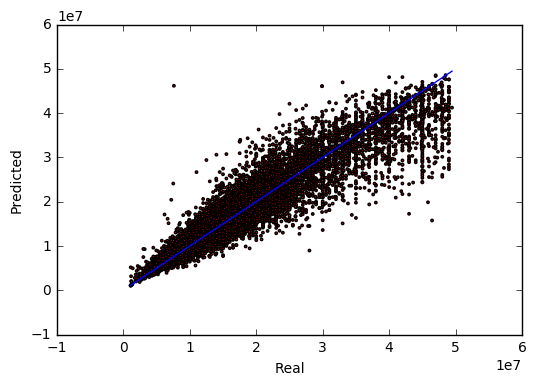

In [19]:
plt.scatter(Y_test_ALL,Y_test_pred_ALL,c='r',s=3*np.ones(len(Y_test_ALL)))
#plt.set_markersize(sz)(3)
plt.plot(  [min(Y_test_ALL),max(Y_test_ALL)],[min(Y_test_ALL),max(Y_test_ALL)],c='b')
plt.xlabel('Real')
plt.ylabel('Predicted')
#plt.plot(  [0,max(Y_test)],[0-1e6,    max(Y_test)-1e6],c='b')
#plt.plot(  [0,max(Y_test)],[0+1e6,    max(Y_test)+1e6],c='b')

plt.show()

In [33]:
df["Price"].value_counts()

11500000    587
10500000    571
12500000    554
8500000     542
7500000     537
9500000     526
6500000     509
7300000     503
8200000     499
5500000     498
7800000     492
12000000    491
5600000     477
6800000     468
11000000    463
6700000     462
8000000     459
9000000     457
13500000    455
5200000     454
5700000     454
6200000     449
6900000     447
6300000     445
6100000     442
5300000     440
8300000     438
7200000     433
13000000    429
5900000     425
           ... 
38067900      1
13844160      1
6905103       1
7032526       1
11476000      1
17719020      1
8067000       1
5152500       1
13940300      1
14321399      1
3203500       1
30830250      1
10886820      1
5463564       1
8240720       1
30015000      1
15998500      1
30047784      1
5787182       1
9612850       1
6504000       1
20553300      1
18890400      1
31719000      1
12580441      1
14278236      1
14843496      1
21967200      1
8638110       1
10657812      1
Name: Price, dtype: int6

In [15]:
len(Y_test_pred_ALL)

29726

In [18]:
df_clean_link = df[out_filter][features + [target_feature]+['Link']].dropna()

In [20]:
df_clean_link[Y_test_pred_ALL/Y_test_ALL>4]['Link']

7046     http://www.cian.ru/sale/flat/142002723/
27217    http://www.cian.ru/sale/flat/153190271/
Name: Link, dtype: object

Balcony_int


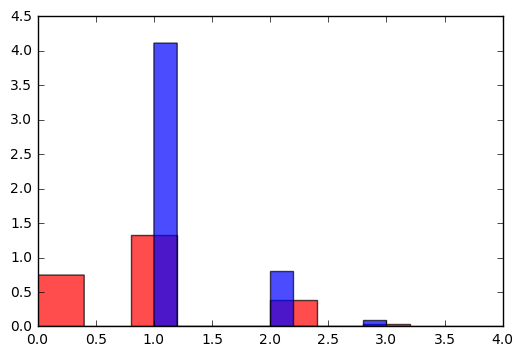

Built_year


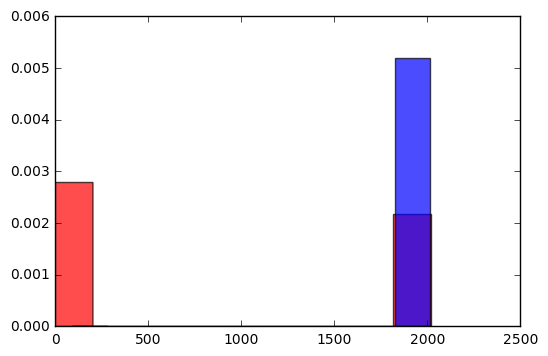

Floor


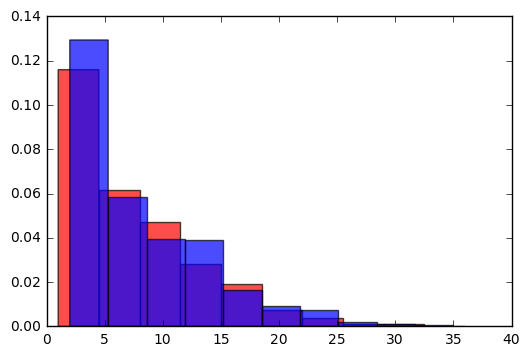

New_int


C:\Users\Artem\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:5991: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


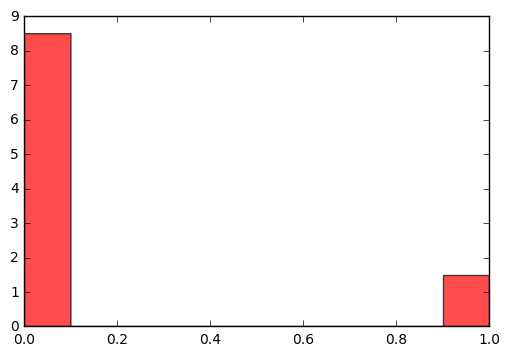

Lift_int


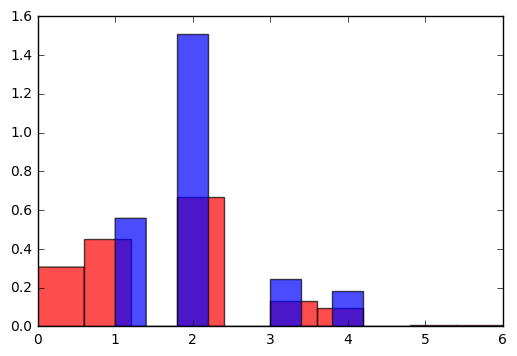

Nfloor


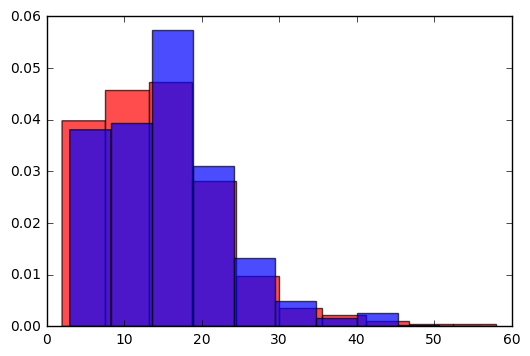

Roof_hight_fl


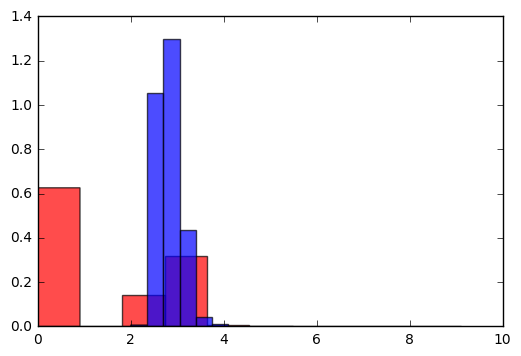

Totsp


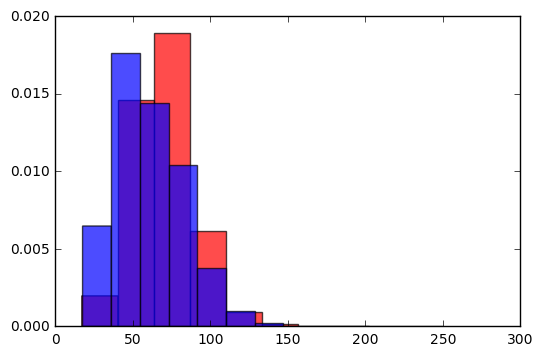

dist


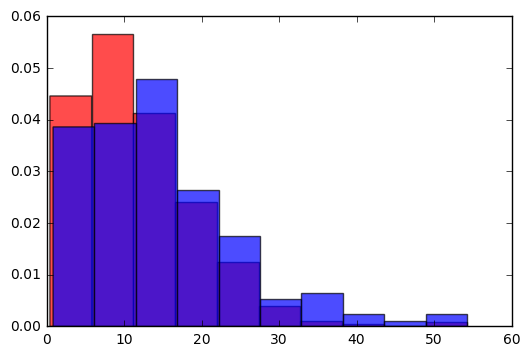

lat


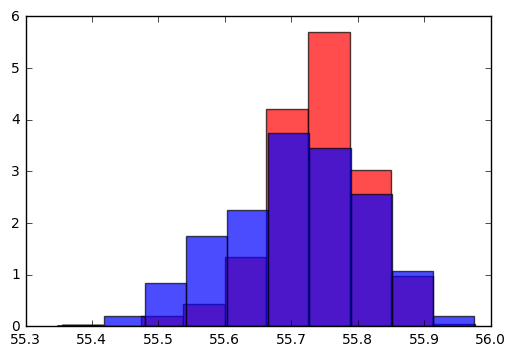

lon


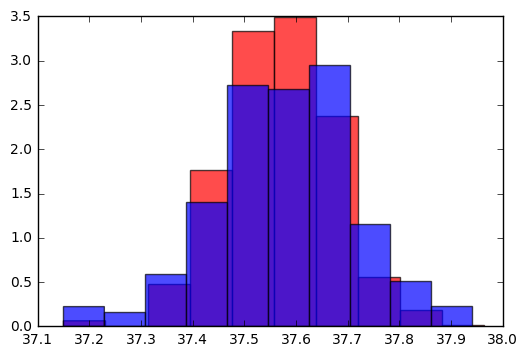

Kitsp


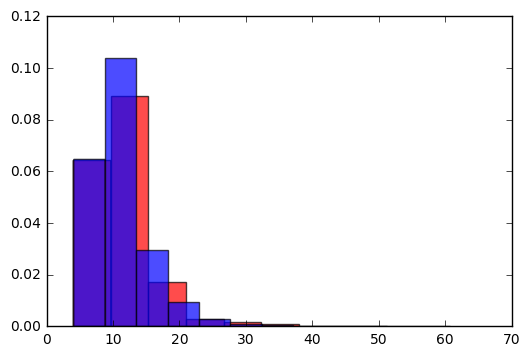

In [31]:
for feature in features:
    print(feature)
    outs = (Y_test_pred_ALL - Y_test_ALL)>2e6
    x_min = min(df_clean[outs][feature])
    x_max = max(df_clean[outs][feature])
    filt = (df_clean[feature]>x_min)&(df_clean[feature]<x_max)
    plt.hist(df_clean[outs][feature], normed=True,color='r',alpha=0.7)
    plt.hist(df_clean[filt][feature], normed=True,color='b',alpha=0.7)
    plt.show()

In [59]:
df_clean[ (Y_test_pred - Y_test)>5e6]

ValueError: Item wrong length 6182 instead of 18731.

In [11]:
feature_for_test = 'Totsp'
print(sum(df[feature_for_test].isnull()))
print(df[feature_for_test].value_counts())

0
60.0     272
75.0     236
54.0     206
80.0     206
40.0     169
70.0     169
39.0     159
38.0     155
45.0     150
52.0     150
55.0     147
76.0     146
64.0     141
65.0     140
78.0     134
74.0     132
58.0     131
56.0     124
50.0     118
53.0     115
35.0     110
32.0     107
73.0     104
100.0    104
42.0     102
33.0     101
72.0      95
77.0      94
59.0      93
68.0      92
        ... 
162.9      1
23.9       1
164.3      1
123.4      1
120.2      1
20.4       1
127.7      1
112.8      1
123.3      1
145.2      1
115.5      1
12.5       1
118.1      1
106.1      1
200.0      1
93.4       1
104.1      1
144.0      1
142.0      1
136.3      1
107.4      1
126.4      1
88.9       1
108.1      1
147.8      1
14.8       1
116.5      1
105.5      1
121.7      1
114.8      1
Name: Totsp, dtype: int64


In [12]:
features = ['Built_year','Floor',]

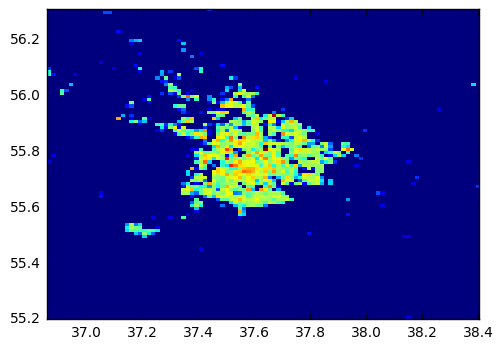

In [91]:
def heat_map(x,y):
    import numpy as np
    import matplotlib.pyplot as plt
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    #print(heatmap)
    plt.clf()
    #plt.figure(figsize=(10,5))
    #plt.imshow(heatmap.T, extent=extent, origin='lower')
    #plt.show()
    plt.imshow(np.log2(heatmap.T+1), extent=extent,interpolation='nearest')
    plt.show()
    #plt.imshow(heatmap.T,extent=extent, interpolation='nearest')
    #plt.show()
heat_map(df[df['dist']<100]['lon'],df[df['dist']<100]['lat'])

In [73]:
from functools import reduce
def lol(a,b):
    return a*b
#reduce( (lambda x, y: x * y), [1, 2, 3, 4] )
reduce( lol, [2, 2, 3, 4] )

48

In [16]:
df.to_excel('a.xlsx')

In [42]:
from functools import reduce
from tqdm import tqdm
text =''
for el in  tqdm(df["Description"]):
    text+=el


100%|███████████████████████████████████████████████████████████████████████████| 15288/15288 [00:56<00:00, 268.80it/s]


In [50]:
import re
split_sim=' '
for el in ['\n',' ','\r','-',',',' ','\tb']:
    split_sim+=('|'+el)

text_splited = re.split(split_sim, text)

In [52]:
a =pd.Series(text_splited).value_counts()

In [13]:
from mpl_toolkits.basemap import Basemap, cm
# requires netcdf4-python (netcdf4-python.googlecode.com)
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import matplotlib.pyplot as plt

# plot rainfall from NWS using special precipitation
# colormap used by the NWS, and included in basemap.

nc = NetCDFFile('../../../examples/nws_precip_conus_20061222.nc')
# data from http://water.weather.gov/precip/
prcpvar = nc.variables['amountofprecip']
data = 0.01*prcpvar[:]
latcorners = nc.variables['lat'][:]
loncorners = -nc.variables['lon'][:]
lon_0 = -nc.variables['true_lon'].getValue()
lat_0 = nc.variables['true_lat'].getValue()
# create figure and axes instances
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=lon_0,lat_0=90.,lat_ts=lat_0,\
            llcrnrlat=latcorners[0],urcrnrlat=latcorners[2],\
            llcrnrlon=loncorners[0],urcrnrlon=loncorners[2],\
            rsphere=6371200.,resolution='l',area_thresh=10000)
# draw coastlines, state and country boundaries, edge of map.
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,10.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
ny = data.shape[0]; nx = data.shape[1]
lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lons, lats) # compute map proj coordinates.
# draw filled contours.
clevs = [0,1,2.5,5,7.5,10,15,20,30,40,50,70,100,150,200,250,300,400,500,600,750]
cs = m.contourf(x,y,data,clevs,cmap=cm.s3pcpn)
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('mm')
# add title
plt.title(prcpvar.long_name+' for period ending '+prcpvar.dateofdata)
plt.show()

ImportError: No module named 'mpl_toolkits.basemap'

In [48]:
mln_boarders=[]
for mln_price in range(380,500,1):
    mln_boarders.append(mln_price*0.1e6)
    #print(mln_price)
    if mln_price%5==0:
        #print('eba')
        mln_boarders.append( (mln_price*0.1e6) + 1 )
        

In [1]:
#get_data_from_page_PART3.py NEW!!!
import pandas as pd
import requests
import re
def html_stripper(text):
    return re.sub('<[^<]+?>', '', str(text))
from bs4 import BeautifulSoup



#Выдаёт не один элемент, а сразу небольшой словарь с переменными
def metro(flat_page,dic):
    #в sth (от англиского something) содержится много того, что нам нужно   
    # сколько миниут до метро и на машине или пешком
    sth = flat_page.find('span', attrs={'class':'object_item_metro_comment'})
    sth = html_stripper(sth)
    sth_list=sth.split('\n')
    sth_list = list(filter(None, sth_list))
    Metrdist = re.findall('\d+', sth)
    if len(Metrdist)==1:
        dic['Metro_time'] = int( Metrdist[0] )
    if 'пешком'in sth:
        dic['Walk_metro']=int(1)
    if 'машин' in sth:
        dic['Walk_metro']=int(0)
    # Станция метро
    sth = flat_page.find('a', attrs={'class':"object_item_metro_name"})
    sth = html_stripper(sth)
    dic["Metro_station"] = str(sth)
    
def add_feat4(dic,sth,spliter1,spliter2, key):
    #sth_list =str(sth).split(spliter)
    sth_list = re.split(spliter1+'|'+spliter2,sth)
    if len(sth_list)>1:
        dic[key] = sth_list[1]
    else:
        dic[key] = sth_list[0]

def many_get3(flat_page):
    #print(flat_page)
    dic ={}
    #Всякая хрень почти из подзаголовка
    sth = flat_page.find('span', attrs={'class':'object_descr_dt_added'})#.contents[1]
    sth=str(sth)
    #print(sth)
    add_feat4(dic=dic ,sth=sth ,spliter1='"deal_type": ',spliter2 = '"publication_date"',key= 'sale')
    add_feat4(dic=dic ,sth=sth ,spliter1='"publication_date": ',spliter2 = ', "id":',key= 'publication_date')
    add_feat4(dic=dic ,sth=sth ,spliter1='"is_premium":',spliter2 = '"deal_type":',key= 'is_premium')
    # Добавать ближайшую (первую в списке из ближайших) станций метро, время на способ добраться (пешком или на машине)
    metro(flat_page,dic)
    
    sth = flat_page.find('div', attrs={'class':'object_descr_text'})
    sth = html_stripper(sth)
    sth.replace('\n',' ')
    #print()
    dic['Description'] = re.sub(' +',' ',sth)
    return(dic)
def get_address(flat_page,dic):
    sth = flat_page.find('h1', attrs={'class':'object_descr_addr'})
    sth = html_stripper(sth)
    sth = sth.replace('\n',' ')
    sth = sth.replace('                       ',' ')
    dic['Address'] = sth
#link_number = 151535540
link_number = 150718150
flat_url = 'http://www.cian.ru/sale/flat/' + str(link_number) + '/'
flat_page = requests.get(flat_url)
flat_page = flat_page.content
flat_page = BeautifulSoup(flat_page, 'lxml')
get_address(flat_page)

TypeError: get_address() missing 1 required positional argument: 'dic'

In [19]:
test_map = Basemap(llcrnrlon=15.2,llcrnrlat=47.06,urcrnrlon=15.5, urcrnrlat=47.49, epsg = 31284,resolution='i',projection='merc',lon_0=14.8,lat_0=47.2)


test__map.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 12000, verbose= True)

OSError: Unable to open boundary dataset file. Only the 'crude' and  'low',
resolution datasets are installed by default.
If you are requesting an, 'intermediate', 'high' or 'full'
resolution dataset, you may need to download and install those
files separately with
`conda install -c conda-forge basemap-data-hires`.